In [1]:
import sys

sys.path.append("../..")
import numpy as np
import torch
from Bio import SeqIO

import tensortree

In [2]:
msa_file = "seq-gen.out"
tree_file = "RAxML_bestTree.out2"
alphabet = "ACGT"

In [3]:
tensortree.set_backend("pytorch")

In [4]:
# parse fasta
leaf_names = []
seqs = []
for record in SeqIO.parse(msa_file, "fasta"):
    leaf_names.append(record.id)
    seqs.append(str(record.seq))

one_hot_leaves = tensortree.util.encode_one_hot(seqs, alphabet=alphabet)
one_hot_leaves = one_hot_leaves[:, np.newaxis] # add model dimension

# create tree
tree = tensortree.TreeHandler.read(tree_file)

In [5]:
def inverse_softplus(x):
    return np.log(np.exp(x) - 1 + 1e-16)

In [6]:
class TreeLogLikelihood(torch.nn.Module):

    def __init__(self):
        super().__init__()
        # create variables, trivially initialize
        R, pi = tensortree.substitution_models.jukes_cantor(d = len(alphabet))
        self.R_kernel = torch.nn.Parameter(torch.from_numpy(inverse_softplus(R)))
        self.pi_kernel = torch.nn.Parameter(torch.from_numpy(np.log(pi)))
        self.B_kernel = torch.nn.Parameter(torch.from_numpy(inverse_softplus(np.ones_like(tree.branch_lengths))))


    def make_R_pi_B(self):
        R = tensortree.model.backend.make_symmetric_pos_semidefinite(self.R_kernel)
        pi = tensortree.model.backend.make_equilibrium(self.pi_kernel)
        B = tensortree.model.backend.make_branch_lengths(self.B_kernel)
        return R, pi, B


    def forward(self, one_hot_leaves, leaf_names, tree):
        R, pi, B = self.make_R_pi_B()
        Q = tensortree.model.backend.make_rate_matrix(R, pi)
        transition_probs = tensortree.backend.make_transition_probs(Q, B)
        L = tensortree.model.loglik(
            one_hot_leaves,
            tree,
            transition_probs,
            torch.log(pi),
            leaf_names=leaf_names,
            leaves_are_probabilities=True
        )
        loss = -torch.mean(L)
        return loss

model = TreeLogLikelihood()

In [7]:
# check initial values
R, pi, B = model.make_R_pi_B()
Q = tensortree.model.backend.make_rate_matrix(R, pi)

print("Initial parameters:")
pi, Q[0], B

Initial parameters:


(tensor([[0.2500, 0.2500, 0.2500, 0.2500]], grad_fn=<SoftmaxBackward0>),
 tensor([[-1.0000,  0.3333,  0.3333,  0.3333],
         [ 0.3333, -1.0000,  0.3333,  0.3333],
         [ 0.3333,  0.3333, -1.0000,  0.3333],
         [ 0.3333,  0.3333,  0.3333, -1.0000]], grad_fn=<SelectBackward0>),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]], grad_fn=<SoftplusBackward0>))

In [8]:
%%time
# model training
lr = 0.05
num_steps = 100

# make a backup for plotting
initial_tree = tensortree.TreeHandler.copy(tree)
initial_tree.set_branch_lengths(B.detach().numpy())

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for step in range(num_steps):
    loss = model(one_hot_leaves, leaf_names, tree)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # test output
    if step < 5 or step % 10 == 0:
        print(f"loss after epoch {step}={loss.detach().numpy()}")

loss after epoch 0=6.581019401550293
loss after epoch 1=6.4624924659729
loss after epoch 2=6.356645107269287
loss after epoch 3=6.262957572937012
loss after epoch 4=6.180355072021484
loss after epoch 10=5.8167877197265625
loss after epoch 20=5.374326705932617
loss after epoch 30=5.101367473602295
loss after epoch 40=4.952712059020996
loss after epoch 50=4.876356601715088
loss after epoch 60=4.847850322723389
loss after epoch 70=4.8413286209106445
loss after epoch 80=4.83888053894043
loss after epoch 90=4.838085651397705
CPU times: user 1min 1s, sys: 5.16 s, total: 1min 6s
Wall time: 3.58 s


In [9]:
R, pi, B = model.make_R_pi_B()
Q = tensortree.model.backend.make_rate_matrix(R, pi)

In [10]:
print("Learned parameters:")
pi, R[0], Q[0]

Learned parameters:


(tensor([[0.0993, 0.1998, 0.3005, 0.4003]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.0000, 1.8744, 0.8975, 1.4309],
         [1.8744, 0.0000, 1.0816, 1.2405],
         [0.8975, 1.0816, 0.0000, 1.6682],
         [1.4309, 1.2405, 1.6682, 0.0000]], grad_fn=<SelectBackward0>),
 tensor([[-1.2528,  0.3855,  0.2777,  0.5896],
         [ 0.1916, -1.0374,  0.3346,  0.5112],
         [ 0.0918,  0.2224, -1.0016,  0.6874],
         [ 0.1463,  0.2551,  0.5160, -0.9175]], grad_fn=<SelectBackward0>))

In [11]:
true_pi = np.array([0.1, 0.2, 0.3, 0.4])

# normalized rate matrix
r = [10, 5, 8, 6, 7, 9]
mut = 2 * (true_pi[0] * true_pi[1] * r[0] + true_pi[0] * true_pi[2] * r[1] + true_pi[0] * true_pi[3] * r[2] +
           true_pi[1] * true_pi[2] * r[3] + true_pi[1] * true_pi[3] * r[4] + true_pi[2] * true_pi[3] *r[5])
rnorm = r / mut
q = [rnorm[0] * true_pi[1], rnorm[1] * true_pi[2], rnorm[2] * true_pi[3],
     rnorm[3] * true_pi[2], rnorm[4] * true_pi[3], rnorm[5] * true_pi[3]]

print("True parameters:")
true_pi, rnorm, q

True parameters:


(array([0.1, 0.2, 0.3, 0.4]),
 array([1.87265918, 0.93632959, 1.49812734, 1.12359551, 1.31086142,
        1.68539326]),
 [np.float64(0.3745318352059925),
  np.float64(0.28089887640449435),
  np.float64(0.599250936329588),
  np.float64(0.3370786516853932),
  np.float64(0.5243445692883895),
  np.float64(0.6741573033707864)])

In [12]:
for learned_branch_length, true_branch_length in zip(B[:,0], tree.branch_lengths[:, 0]):
    print(learned_branch_length.detach().numpy(), true_branch_length)

0.29551044 0.3017016
0.29968438 0.3013877
0.19726324 0.2005827
0.098489024 0.100148804
0.09869839 0.09924722
0.30481333 0.29687506
0.10516732 0.10143233


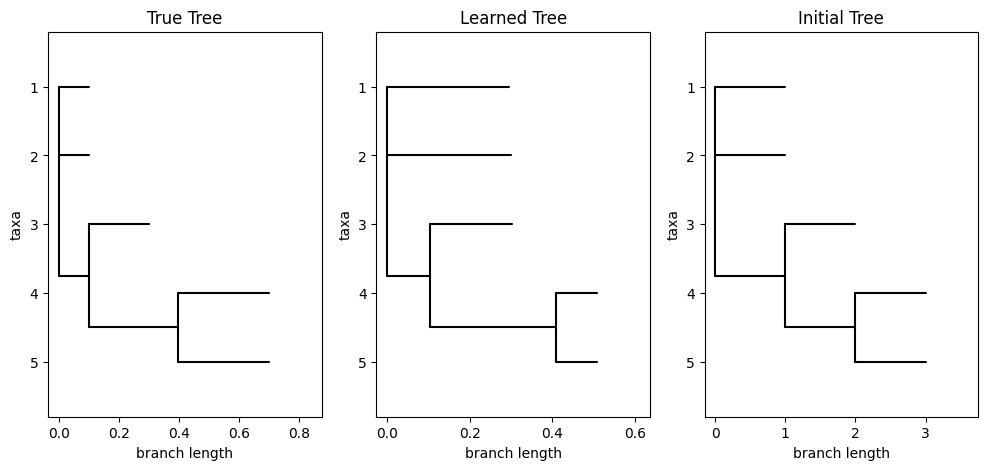

In [13]:
# draw and save as png
import matplotlib.pyplot as plt
%matplotlib inline

# Create figure with two subplots
figure, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 5))

# draw the true tree
tree.draw(axes=ax0, no_labels=True, do_show=False)
ax0.set_title("True Tree")

# draw the learned tree
learned_tree = tensortree.TreeHandler.copy(tree)
learned_tree.set_branch_lengths(B.detach().numpy())
learned_tree.draw(axes=ax1, no_labels=True, do_show=False)
ax1.set_title("Learned Tree")

# draw the initial tree
initial_tree.draw(axes=ax2, no_labels=True, do_show=False)
ax2.set_title("Initial Tree")

figure.show()
